In [ ]:
%%capture
# !pip install unsloth
# !pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

# %%capture
# Normally using pip install unsloth (the above code) is enough
# Temporarily as of Jan 31st 2025, Colab has some issues with Pytorch
# Using pip install unsloth will take 3 minutes, whilst the below takes <1 minute:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers.git@1931a351408dbd1d0e2c4d6d7ee0eb5e8807d7bf
# there are some issues with using the qwen VL 3B model: https://github.com/huggingface/transformers/issues/36193
# so i have to uninstall and reinstall the transformers above
# might change to new model later on. update: i am using the official qwen model instead

In [ ]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    # jack: i think we just try LoRA, since we are already doing a small 2-3B model. QLoRA might make it worse.
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.15: Fast Qwen2_5_Vl vision patching. Transformers: 4.49.0.dev0.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    # i think we can set all True. but feel free to set false to speed up your individual experiments
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True,  # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True,  # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least, later we will adjust this
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",]
)

<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of general question and answering pairs. These datasets should be mixed with other finetunes to not make the model forget general tasks.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/llava-instruct-mix-vsft-mini). The full dataset is [here](https://huggingface.co/datasets/HuggingFaceH4/llava-instruct-mix-vsft).

In [ ]:
from datasets import load_dataset

# It is best to ensure your dataset has images of all the same size/dimensions.
# Use dimensions of 300-1000px to ensure your training does not take too long or use too many resources.
# we can work on this later on
dataset = load_dataset("unsloth/llava-instruct-mix-vsft-mini", split = "train")

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [ ]:
dataset

Dataset({
    features: ['messages', 'images'],
    num_rows: 8552
})

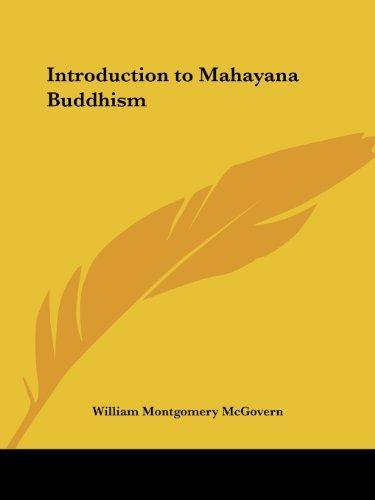

In [ ]:
dataset[20]["images"][0]

In [ ]:
dataset[20]["messages"]

[{'content': [{'index': None,
    'text': 'Who wrote this book?\n',
    'type': 'text'},
   {'index': 0, 'text': None, 'type': 'image'}],
  'role': 'user'},
 {'content': [{'index': None,
    'text': 'William Montgomery McGovern',
    'type': 'text'}],
  'role': 'assistant'},
 {'content': [{'index': None,
    'text': 'What is the title of this book?',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'index': None,
    'text': 'Introduction to Mahayana Buddhism',
    'type': 'text'}],
  'role': 'assistant'},
 {'content': [{'index': None,
    'text': 'What type of book is this?',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'index': None,
    'text': 'Religion & Spirituality',
    'type': 'text'}],
  'role': 'assistant'},
 {'content': [{'index': None,
    'text': 'Is this a religious book?',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'index': None, 'text': 'Yes', 'type': 'text'}],
  'role': 'assistant'},
 {'content': [{'index': None,
    'text': 'Is this a c

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "paged_adamw_8bit", # maybe adjust optim next time
        weight_decay = 0.01,
        lr_scheduler_type = "linear", # TWEAK THIS FOR CS7643 LATER ON WHEN WE SCALE UP. for now can just leave it as LINEAR
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.164 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 8,552 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 4
\        /    Total batch size = 4 | Total steps = 30
 "-____-"     Number of trainable parameters = 37,152,768
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.385800
2,3.684800
3,2.555700
4,2.715200
5,2.097700
6,1.350500
7,1.580800
8,1.209300
9,0.913000
10,1.319100


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

NameError: name 'trainer_stats' is not defined

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[20]["images"][0]
instruction = "what is written in the book?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)


The text "Introduction to Mahayana Buddhism" by William Montgomery McGovern is the title of the book. The author, William Montgomery McGovern, is likely discussing and providing an overview of Mahayana Buddhism, which is one of the major schools of Buddhism.<|im_end|>


## Visualisation Resources-
- https://arxiv.org/pdf/2404.19128
- https://arxiv.org/pdf/1610.02391
- https://github.com/jacobgil/pytorch-grad-cam
- http://opensource.salesforce.com/OmniXAI/latest/tutorials/vision/gradcam_vlm.html

# Visualisation Code

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration

model = Qwen2_5_VLForConditionalGeneration.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# !pip install transformers accelerate qwen-vl-utils==0.0.8 torch torchvision
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

# !pip install grad-cam

In [ ]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms import Resize
from PIL import Image
import numpy as np

In [ ]:
# Load model and processor
model = Qwen2_5_VLForConditionalGeneration.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto")

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

In [ ]:
# Prepare input
image_path = 'im.jpeg' # "path/to/your/image.jpg"
question = "What shape is in the center of the book?"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path},
            {"type": "text", "text": question},
        ],
    }
]

In [ ]:
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, _ = process_vision_info(messages)

In [ ]:
inputs = processor(text=[text], images=image_inputs, return_tensors="pt")
inputs = inputs.to('cuda').to(torch.long)

In [ ]:
# inputs['pixel_values'] = inputs['pixel_values'].long()

In [ ]:
inputs

{'input_ids': tensor([[151644,   8948,    198,  ..., 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0, -1],
        [ 0,  0,  0,  ...,  0, -1,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], device='cuda:0'), 'image_grid_thw': tensor([[ 1, 74, 54]], device='cuda:0')}

In [ ]:
from pytorch_grad_cam import GradCAM

cam = GradCAM(model=model, target_layers=[target_layer])

In [ ]:
# Define target layer for Grad-CAM. i.e last layer from visual block.
target_layer = model.visual.blocks[-1]

# Create GradCAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Generate Grad-CAM heatmap
grayscale_cam = cam(input_tensor=inputs.pixel_values, targets=None)

OutOfMemoryError: CUDA out of memory. Tried to allocate 17.93 GiB. GPU 0 has a total capacity of 14.74 GiB of which 7.28 GiB is free. Process 188253 has 7.46 GiB memory in use. Of the allocated memory 7.14 GiB is allocated by PyTorch, and 213.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Load and preprocess the original image
image = Image.open(image_path).convert("RGB")
image = Resize((224, 224))(image)
rgb_img = np.array(image) / 255

# Overlay heatmap on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam[0, :], use_rgb=True)

# Display or save the visualization
Image.fromarray(visualization).show()

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["images"][0]
instruction = "What colors are in the image?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The image features the colors black, orange, white, and gray.</s>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")